<a href="https://colab.research.google.com/github/MisaelManingo/ChemVATS/blob/main/ChemE_197_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ChemE 191 Final Project**
by Misael Andre D. Maningo

**Tuning Hyperparameters**

# Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, BatchNormalization, Activation, AveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import Javascript, display
from google.colab import output

!pip install selfies
import selfies as sf

!pip install keras-tuner --upgrade
import keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Dataset
from https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv

In [ ]:
#@title Dataset
df = pd.read_csv("https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", "")) # removes '\n' from the SMILES column
display(df.head(100))

print("Total number of molecules in imported dataset:", len(df.index))

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
...,...,...,...,...
95,C=CCN(Cc1cccc([N+](=O)[O-])c1)C(=O)Nc1cc(OC)cc...,4.47690,0.419977,2.204004
96,Cc1cc(Cl)ccc1OCC(=O)N/N=C/c1ccccn1,2.57252,0.680288,2.075582
97,O=C1NC(=S)NC(=O)C1=CNc1ccc([N+](=O)[O-])cc1O,0.12710,0.159707,2.703933
98,Cc1c(C(=O)N2CCOCC2)oc2c1-c1nn(CC(=O)NCc3ccco3)...,1.93192,0.675385,2.845261


Total number of molecules in imported dataset: 249455


# Preprocessing

In [ ]:
#@title SMILES to SELFIES
# @markdown Forms support many types of fields.
LOAD_FROM_FILE = True # @param {type: "boolean"}
MASTER_SELFIES_FILE_NAME = '/content/drive/MyDrive/BS ChemE/4th Year, 2nd Sem/ChemE 197/FINAL PROJECT/master_SELFIES.txt' # @param {type: "string"}

if not LOAD_FROM_FILE:
    master_SELFIES = [sf.encoder(s) for s in df.iloc[:, 0]]
    with open(MASTER_SELFIES_FILE_NAME, 'w') as file:
        for item in master_SELFIES:
            file.write(f"{item}\n")
else:
    master_SELFIES = []
    with open(MASTER_SELFIES_FILE_NAME, 'r') as file:
        for line in file:
            master_SELFIES.append(line.strip())

max_length = max(sf.len_selfies(s) for s in master_SELFIES)
print(f"Maximum length of SELFIES: {max_length}")

# @markdown ---

Maximum length of SELFIES: 72


In [ ]:
#@title Vocabulary {vertical-output: true}
alphabet = sf.get_alphabet_from_selfies(master_SELFIES)
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']
alphabet.insert(0, "[nop]") # [nop] is a special padding symbol. Placed at position 0
vocab_size = len(alphabet)

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'''))
print(f"Vocabulary size: {vocab_size}\n")
for k, v in idx_to_symbol.items():
    print(k, v)

<IPython.core.display.Javascript object>

Vocabulary size: 108

0 [nop]
1 [#Branch1]
2 [#Branch2]
3 [#C]
4 [#N+1]
5 [#N]
6 [-/Ring1]
7 [-/Ring2]
8 [-\Ring1]
9 [/Br]
10 [/C@@H1]
11 [/C@@]
12 [/C@H1]
13 [/C@]
14 [/C]
15 [/Cl]
16 [/F]
17 [/N+1]
18 [/N-1]
19 [/NH1+1]
20 [/NH1-1]
21 [/NH1]
22 [/NH2+1]
23 [/N]
24 [/O+1]
25 [/O-1]
26 [/O]
27 [/S-1]
28 [/S@]
29 [/S]
30 [=Branch1]
31 [=Branch2]
32 [=C]
33 [=N+1]
34 [=N-1]
35 [=NH1+1]
36 [=NH2+1]
37 [=N]
38 [=O+1]
39 [=OH1+1]
40 [=O]
41 [=P@@]
42 [=P@]
43 [=PH2]
44 [=P]
45 [=Ring1]
46 [=Ring2]
47 [=S+1]
48 [=S@@]
49 [=S@]
50 [=SH1+1]
51 [=S]
52 [Br]
53 [Branch1]
54 [Branch2]
55 [C@@H1]
56 [C@@]
57 [C@H1]
58 [C@]
59 [CH1-1]
60 [CH2-1]
61 [C]
62 [Cl]
63 [F]
64 [I]
65 [N+1]
66 [N-1]
67 [NH1+1]
68 [NH1-1]
69 [NH1]
70 [NH2+1]
71 [NH3+1]
72 [N]
73 [O-1]
74 [O]
75 [P+1]
76 [P@@H1]
77 [P@@]
78 [P@]
79 [PH1+1]
80 [PH1]
81 [P]
82 [Ring1]
83 [Ring2]
84 [S+1]
85 [S-1]
86 [S@@+1]
87 [S@@]
88 [S@]
89 [S]
90 [\Br]
91 [\C@@H1]
92 [\C@H1]
93 [\C]
94 [\Cl]
95 [\F]
96 [\I]
97 [\N+1]
98 [\N-1]
99 [\NH1+1]


In [ ]:
#@title SELFIES to INTEGER ENCODING
# @markdown Converts SELFIES string to integer encoding.
LOAD_FROM_FILE = True # @param {type: "boolean"}
MASTER_SET_FILE_NAME = '/content/drive/MyDrive/BS ChemE/4th Year, 2nd Sem/ChemE 197/FINAL PROJECT/master_set.npy' # @param {type: "string"}

if not LOAD_FROM_FILE:
    assert vocab_size < 126, "WARNING: Use of int8 might not represent all SELFIES. Use int16 or higher instead."
    master_set = np.empty((len(master_SELFIES),), dtype=np.ndarray)
    for x in range(len(master_SELFIES)):
        if x % 10_000 == 0:
            output.clear()
            print(f"Processed molecules: {x}")
        master_set[x] = np.array(sf.selfies_to_encoding(
            selfies = master_SELFIES[x],
            vocab_stoi = symbol_to_idx,
            pad_to_len = max_length,
            enc_type = "label"
        )).astype(np.int8) # int8 only stores integers from -127 to 127 ONLY!!!
    master_set = np.vstack(master_set[0:len(master_set)])
    np.save(MASTER_SET_FILE_NAME, master_set)
    print("Saved npy file.")
else:
    master_set = np.load(MASTER_SET_FILE_NAME)
    print("Loaded npy file to master_set.")

Loaded npy file to master_set.


In [ ]:
# @title Data splitting
logP_set = np.squeeze(df[["logP"]].to_numpy())
qed_set = np.squeeze(df[["qed"]].to_numpy())
SAS_set = np.squeeze(df[["SAS"]].to_numpy())
int_train,int_test, logP_train,logP_test, qed_train,qed_test, SAS_train,SAS_test = train_test_split(master_set, logP_set, qed_set, SAS_set, test_size=0.05, random_state=42)

# Hyperparameter Tuning



In [ ]:
#@title Setup Model and Tuner
# @markdown Hyperparameter tuner settings
def build_model(hp):
    input = Input((max_length,), dtype='int32', name='TestInput')

    x = Embedding(
                input_dim=vocab_size,
                output_dim=hp.Choice("embedDim", [64, 128]),
                input_length=max_length,
                mask_zero=True,
                name='TokenEmbedding',
            )(input)

    useConv = hp.Boolean("convolution")
    with hp.conditional_scope("convolution", True):
        if useConv:
            x = Conv1D(filters=hp.Int("numFilter",34,64,32), kernel_size=hp.Int("kernelSize",3,5))(x)
            if hp.Boolean("batchN"):
                x = BatchNormalization()(x)
            x = Activation('relu')(x)

    num_expand_layers = hp.Int("numExpandLayers", 1, 2)
    activation_Expand = hp.Choice("expandActivation", ["relu", "tanh"])
    for i in range(num_expand_layers):
        with hp.conditional_scope("numExpandLayers", list(range(i + 1, 3 + 1))):
            x = Dense(
                    units=hp.Int(f"expandUnits_{i+1}", min_value=32, max_value=64, step=32),
                    activation=activation_Expand,
                    name=f"DenseExpand{i+1}"
                )(x)

    pooling_type = hp.Choice("PoolingType", ["Average","Max","AveMax"])
    if pooling_type == "Average":
        x = GlobalAveragePooling1D(name="GlobalAveragePooling1D")(x)
    elif pooling_type == "Max":
        x = GlobalMaxPooling1D(name="GlobalMaxPooling1D")(x)
    elif pooling_type == "AveMax":
        x = AveragePooling1D(3, name="AveragePooling1D")(x)
        x = GlobalMaxPooling1D(name="GlobalMaxPooling1D")(x)

    num_shrink_layers = hp.Int("numShrinkLayers", 1, 2)
    activation_Shrink = hp.Choice("shrinkActivation", ["relu", "tanh"])
    for i in range(num_shrink_layers):
        with hp.conditional_scope("numShrinkLayers", list(range(i + 1, 3 + 1))):
            x = Dense(
                    units=hp.Int(f"shrinkUnits_{i+1}", min_value=26, max_value=39, step=13),
                    activation=activation_Shrink,
                    name=f"DenseShrink{i+1}"
                )(x)

    output_logP = Dense(1, activation='linear', name="logPLayer")(x)
    output_qed = Dense(1, activation='linear', name="qedLayer")(x)
    output_SAS = Dense(1, activation='linear', name="SASLayer")(x)

    model = Model(input, [output_logP,output_qed,output_SAS], name="Mowdel")
    learning_rate = hp.Float("learningRate", min_value=1e-4, max_value=1e-2, step=10, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', keras.metrics.RootMeanSquaredError()],
    )
    return model

max_trials = 32 # @param {type: "slider", min: 1, max: 64}
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=max_trials,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True,
    directory="/content/tmp/tb",
)

tuner.search_space_summary()

Search space summary
Default search space size: 13
embedDim (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
convolution (Boolean)
{'default': False, 'conditions': []}
numExpandLayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
expandActivation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
expandUnits_1 (Int)
{'default': None, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'numExpandLayers', 'values': [1, 2, 3]}}], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
PoolingType (Choice)
{'default': 'Average', 'conditions': [], 'values': ['Average', 'Max', 'AveMax'], 'ordered': False}
numShrinkLayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
shrinkActivation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
shrink

In [ ]:
#@title Tuning
# @markdown Tuning settings
epochs = 20 # @param {type: "slider", min: 1, max: 32}
dataset_size = 10000 # @param {type: "slider", min: 1000, max: 25000}
tuner.search(
    int_train[:dataset_size],
    [logP_train[:dataset_size],qed_train[:dataset_size],SAS_train[:dataset_size]],
    epochs=epochs,
    validation_split = 0.1,
    callbacks=[keras.callbacks.TensorBoard("/content/tmp/tb_logs")],
)
best_model = tuner.get_best_models()[0]
best_model.summary()
tuner.results_summary()

Trial 32 Complete [00h 02m 28s]
val_loss: 1.1818547248840332

Best val_loss So Far: 0.17821012437343597
Total elapsed time: 01h 04m 34s


AttributeError: 'list' object has no attribute 'summary'

# Best Model

Model: "Mowdel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TestInput (InputLayer)      [(None, 72)]                 0         []                            
                                                                                                  
 TokenEmbedding (Embedding)  (None, 72, 64)               6912      ['TestInput[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 69, 34)               8738      ['TokenEmbedding[0][0]']      
                                                                                                  
 batch_normalization_1 (Bat  (None, 69, 34)               136       ['conv1d_1[0][0]']            
 chNormalization)                                                                            

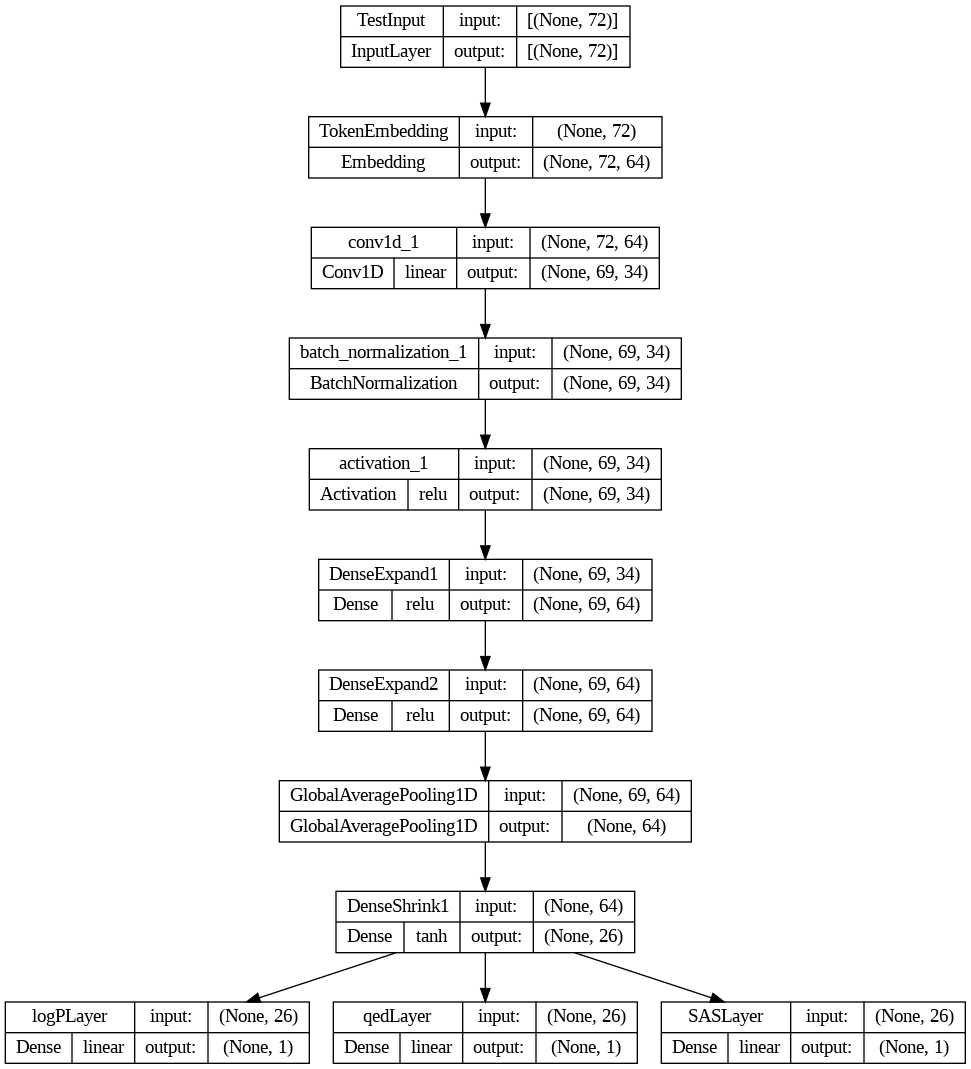

In [ ]:
#@title Best Model {vertical-output: true}
nn = build_model(tuner.get_best_hyperparameters()[0])
nn.summary()

keras.utils.plot_model(
    nn,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
    show_layer_activations=True,
)

In [ ]:
# @title Training of Neural Network
# @markdown Forms support many types of fields.

TRAIN_LOAD = "TRAIN" # @param ['TRAIN', 'LOAD']
TRAIN_SAVE = True # @param {type: "boolean"}
TRAIN_WEIGHTS_FOLDER = "/content/drive/MyDrive/BS ChemE/4th Year, 2nd Sem/ChemE 197/FINAL PROJECT/"
FILENAME = "LQS_PharML.h5" # @param {type: "string"}
TRAIN_WEIGHTS_FILE = TRAIN_WEIGHTS_FOLDER + FILENAME
EPOCH = 200 # @param {type: "slider", min: 1, max: 200}

if TRAIN_LOAD == "TRAIN":
    print("TRAINING!")
    for i in range(len(nn.weights)):
        nn.weights[i]._handle_name = nn.weights[i].name + "_" + str(i)

    early_stop = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 3,
        min_delta = 0.0001,
        verbose = True,
    )

    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
    test_history = nn.fit(
        x = int_train,
        y = [logP_train,qed_train,SAS_train],
        epochs = EPOCH,
        batch_size = 64,
        shuffle = True,
        validation_split = 0.05,
        callbacks = [
            # checkpoint,
            early_stop, # may be disabled to prevent premature early stop
            # backup,
            # tb, # may crash training
        ],
    )
    if TRAIN_SAVE:
        nn.save_weights(TRAIN_WEIGHTS_FILE)
        print("SAVE succesful!")
elif TRAIN_LOAD == "LOAD":
    nn.load_weights(TRAIN_WEIGHTS_FILE)
    print("LOAD succesful!")

TRAINING!


<IPython.core.display.Javascript object>

Epoch 1/200
3518/3518 [==============================] - 97s 26ms/step - loss: 0.4188 - logPLayer_loss: 0.2844 - qedLayer_loss: 0.0149 - SASLayer_loss: 0.1195 - logPLayer_mae: 0.3728 - logPLayer_root_mean_squared_error: 0.5333 - qedLayer_mae: 0.0924 - qedLayer_root_mean_squared_error: 0.1219 - SASLayer_mae: 0.2306 - SASLayer_root_mean_squared_error: 0.3456 - val_loss: 0.1886 - val_logPLayer_loss: 0.1211 - val_qedLayer_loss: 0.0105 - val_SASLayer_loss: 0.0569 - val_logPLayer_mae: 0.2698 - val_logPLayer_root_mean_squared_error: 0.3480 - val_qedLayer_mae: 0.0802 - val_qedLayer_root_mean_squared_error: 0.1025 - val_SASLayer_mae: 0.1869 - val_SASLayer_root_mean_squared_error: 0.2386
Epoch 2/200
3518/3518 [==============================] - 92s 26ms/step - loss: 0.1869 - logPLayer_loss: 0.1276 - qedLayer_loss: 0.0099 - SASLayer_loss: 0.0494 - logPLayer_mae: 0.2743 - logPLayer_root_mean_squared_error: 0.3572 - qedLayer_mae: 0.0776 - qedLayer_root_mean_squared_error: 0.0995 - SASLayer_mae: 0.16

In [ ]:
# nn.save('/content/drive/MyDrive/BS ChemE/4th Year, 2nd Sem/ChemE 197/FINAL PROJECT/LQSPharML.keras')
nn = keras.models.load_model('/content/drive/MyDrive/BS ChemE/4th Year, 2nd Sem/ChemE 197/FINAL PROJECT/LQSPharML.keras')

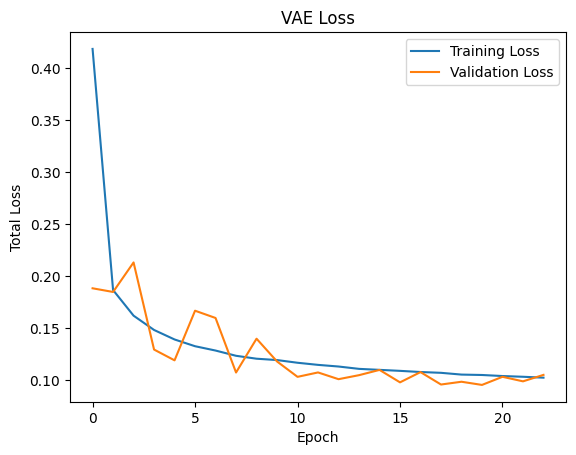

In [ ]:
#@title Learning Graph {vertical-output: true}
plt.plot(test_history.history['loss'])
plt.plot(test_history.history['val_loss'])
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

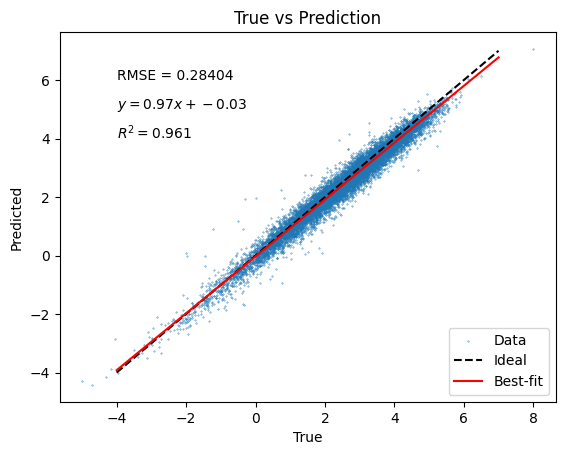

In [ ]:
#@title True vs Prediction logP Graph {vertical-output: true}
lim = np.array([-4,7])

prop_predict = nn.predict(int_test,verbose=0)[0]
plt.scatter(logP_test, prop_predict, s=0.1)

plt.plot(lim, lim, label='y = x', color='black', linestyle='dashed')

m, b = np.polyfit(logP_test, prop_predict, 1)
plt.plot(lim, m*lim+b, color='red')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')

plt.text(-4, 6, f'RMSE = {math.sqrt(mean_squared_error(logP_test, prop_predict)):.5f}', fontsize = 10)
plt.text(-4, 5, f'$y = {m[0]:.2f}x + {b[0]:.2f}$', fontsize = 10)
plt.text(-4, 4, f'$R^2 = {r2_score(logP_test, prop_predict):.3f}$', fontsize = 10)

plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

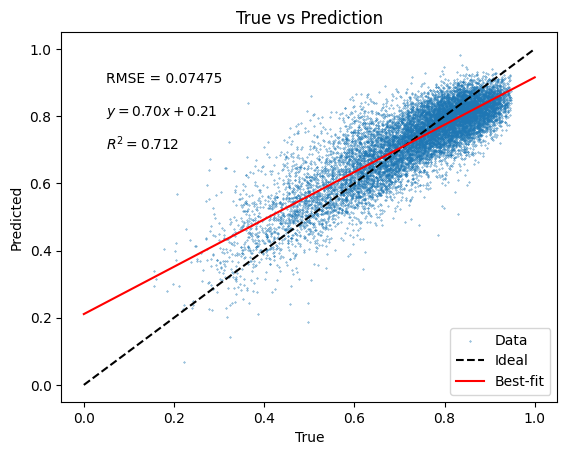

In [65]:
#@title True vs Prediction QED Graph {vertical-output: true}
lim = np.array([0,1])

prop_predict = nn.predict(int_test,verbose=0)[1]
plt.scatter(qed_test, prop_predict, s=0.1)

plt.plot(lim, lim, label='y = x', color='black', linestyle='dashed')

m, b = np.polyfit(qed_test, prop_predict, 1)
plt.plot(lim, m*lim+b, color='red')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')

plt.text(0.05, 0.9, f'RMSE = {math.sqrt(mean_squared_error(qed_test, prop_predict)):.5f}', fontsize = 10)
plt.text(0.05, 0.8, f'$y = {m[0]:.2f}x + {b[0]:.2f}$', fontsize = 10)
plt.text(0.05, 0.7, f'$R^2 = {r2_score(qed_test, prop_predict):.3f}$', fontsize = 10)

plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

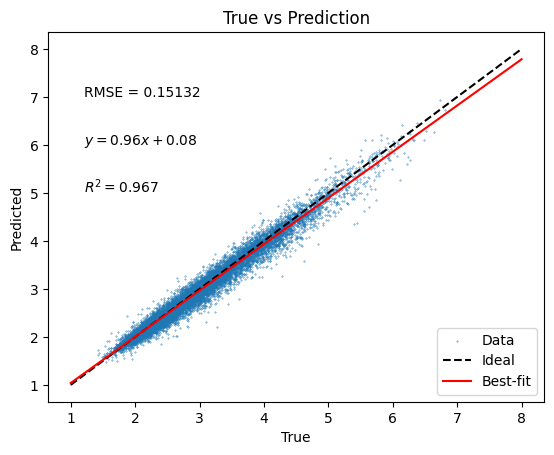

In [ ]:
#@title True vs Prediction SAS Graph {vertical-output: true}
lim = np.array([1,8])

prop_predict = nn.predict(int_test,verbose=0)[2]
plt.scatter(SAS_test, prop_predict, s=0.1)

plt.plot(lim, lim, label='y = x', color='black', linestyle='dashed')

m, b = np.polyfit(SAS_test, prop_predict, 1)
plt.plot(lim, m*lim+b, color='red')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')

plt.text(1.2, 7, f'RMSE = {math.sqrt(mean_squared_error(SAS_test, prop_predict)):.5f}', fontsize = 10)
plt.text(1.2, 6, f'$y = {m[0]:.2f}x + {b[0]:.2f}$', fontsize = 10)
plt.text(1.2, 5, f'$R^2 = {r2_score(SAS_test, prop_predict):.3f}$', fontsize = 10)

plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

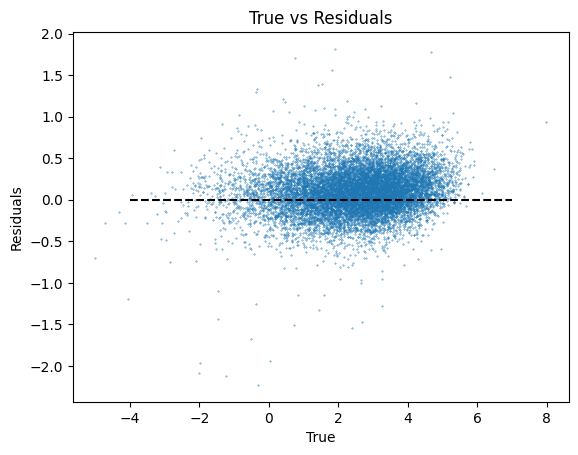

In [ ]:
#@title Residual Graph {vertical-output: true}
lim = np.array([-5,8])

true = logP_test
pred = nn.predict(int_test,verbose=0)[0]

X = true
Y = true - np.squeeze(pred)
plt.scatter(X, Y, s=0.1)

plt.plot(lim, [0,0], label='y = x', color='black', linestyle='dashed')

plt.xlabel('True')
plt.ylabel('Residuals')
plt.title('True vs Residuals')

# plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

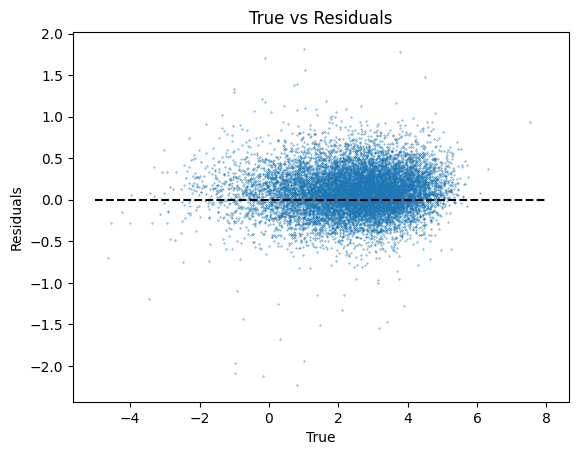

In [ ]:
#@title  Bland-Altman Plot (Difference Plot) {vertical-output: true}
lim = np.array([-5,8])

true = logP_test
pred = np.squeeze(nn.predict(int_test,verbose=0)[0])

X = (true + pred) / 2
Y = true - pred
plt.scatter(X, Y, s=0.1)

plt.plot(lim, [0,0], label='y = x', color='black', linestyle='dashed')

plt.xlabel('Mean')
plt.ylabel('Residuals')
plt.title('Mean vs Residuals')

# plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

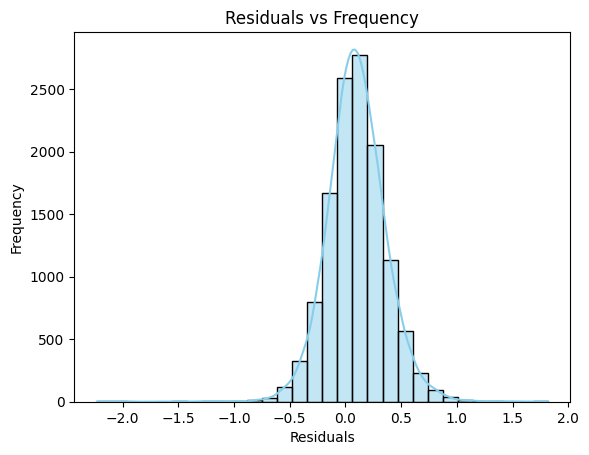

In [ ]:
#@title  Histogram {vertical-output: true}
true = logP_test
pred = np.squeeze(nn.predict(int_test,verbose=0)[0])

error = true - pred
# plt.hist(error, bins=50, color='skyblue', edgecolor='black')
sns.histplot(error, bins=30, kde=True, color='skyblue', edgecolor='black')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals vs Frequency')

plt.show()

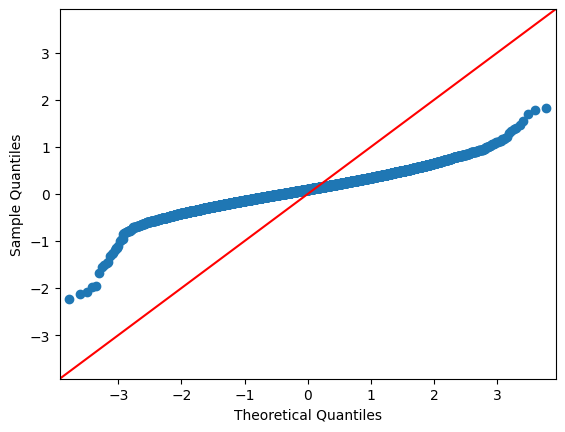

In [ ]:
#@title Q-Q Plot (Quantile-Quantile Plot) {vertical-output: true}
import statsmodels.api as sm
import pylab as py
import matplotlib.gridspec as gridspec

sm.qqplot(error, line ='45')
py.show()

<ipython-input-66-f1cbdd3a6501>:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


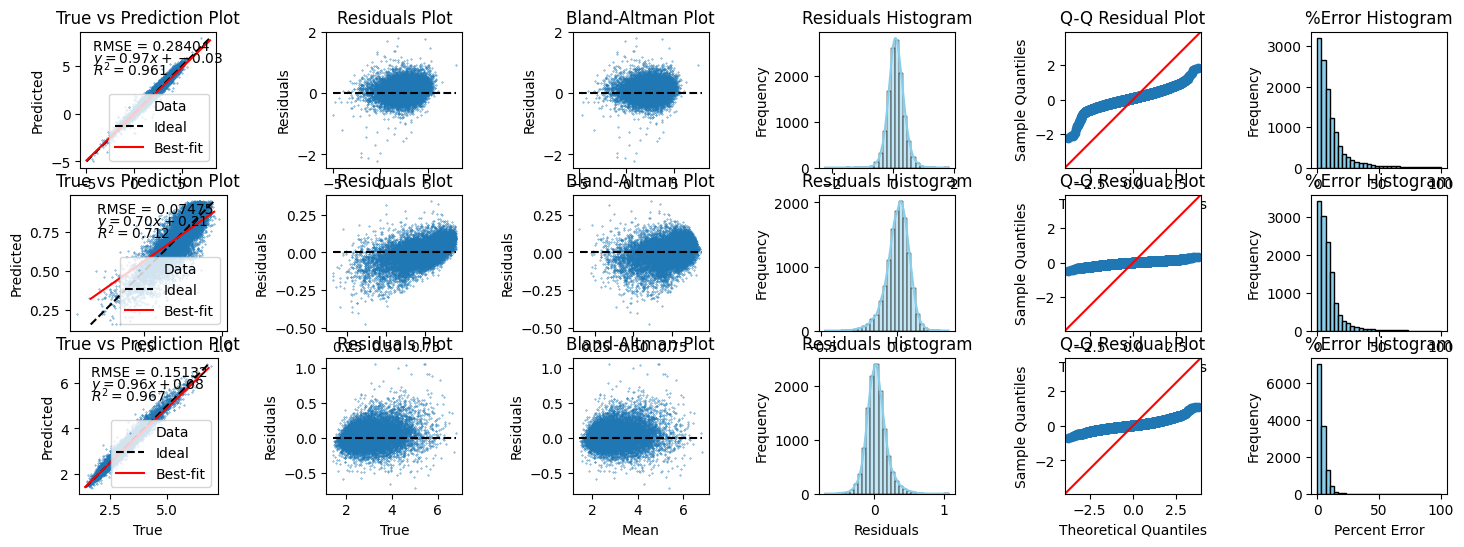

In [66]:
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1], wspace=0.5)
test_arr = np.array([logP_test,qed_test,SAS_test])
pred_arr = np.squeeze(nn.predict(int_test,verbose=0))

for i in range(3):
    true = test_arr[i]
    # pred = np.squeeze(nn.predict(int_test,verbose=0)[i])
    pred = pred_arr[i]
    residuals = true - pred
    percent_error = [x for x in abs(1 - pred/true) * 100 if x <= 100]
    lim = np.array([min(true),max(true)])
    text_pos_x = 0.05 * (lim[1]-lim[0]) + lim[0]
    text_pos_y = lim[1] - np.array([0.1,0.2,0.3]) * (lim[1]-lim[0])


    # True vs Predict Graph ---------------------
    ax1 = fig.add_subplot(gs[i, 0], aspect='equal')
    ax1.scatter(pred, true, s=0.1)

    ax1.plot(lim, lim, label='y = x', color='black', linestyle='dashed')

    m, b = np.polyfit(true, pred, 1)
    ax1.plot(lim, m*lim+b, color='red')

    ax1.set_xlabel('True')
    ax1.set_ylabel('Predicted')
    ax1.set_title('True vs Prediction Plot')

    ax1.text(text_pos_x, text_pos_y[0], f'RMSE = {math.sqrt(mean_squared_error(true, pred)):.5f}', fontsize = 5)
    ax1.text(text_pos_x, text_pos_y[1], f'$y = {m:.2f}x + {b:.2f}$', fontsize = 5)
    ax1.text(text_pos_x, text_pos_y[2], f'$R^2 = {r2_score(true, pred):.3f}$', fontsize = 5)

    ax1.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

    # True vs Residuals Graph ---------------------
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.scatter(true, residuals, s=0.1)
    ax2.plot(lim, [0,0], label='y = x', color='black', linestyle='dashed')
    ax2.set_xlabel('True')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals Plot')
    ax2.set_box_aspect(1)

    # Bland-Altman Plot (Difference Plot) -------------------
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.scatter((true+pred)/2, residuals, s=0.1)
    ax3.plot(lim, [0,0], label='y = x', color='black', linestyle='dashed')
    ax3.set_xlabel('Mean')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Bland-Altman Plot')
    ax3.set_box_aspect(1)

    # Residuals Histogram ----------------
    ax4 = fig.add_subplot(gs[i, 3])
    sns.histplot(residuals, bins=30, kde=True, color='skyblue', edgecolor='black')
    ax4.set_xlabel('Residuals')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Residuals Histogram')
    ax4.set_box_aspect(1)

    # Q-Q Plot (Quantile-Quantile Plot) ----------------------
    ax5 = fig.add_subplot(gs[i, 4], aspect='equal')
    sm.qqplot(residuals, line ='45', ax=ax5)
    ax5.set_title('Q-Q Residual Plot')

    # Percent Error Histogram ----------------------
    ax6 = fig.add_subplot(gs[i, 5])
    ax6.hist(percent_error, bins=30, color='skyblue', edgecolor='black', range=[0, 100])
    # sns.histplot(percent_error, bins=30, color='skyblue', edgecolor='black')
    ax6.set_xlabel('Percent Error')
    ax6.set_ylabel('Frequency')
    ax6.set_title('%Error Histogram')
    ax6.set_box_aspect(1)

plt.tight_layout()
plt.show()

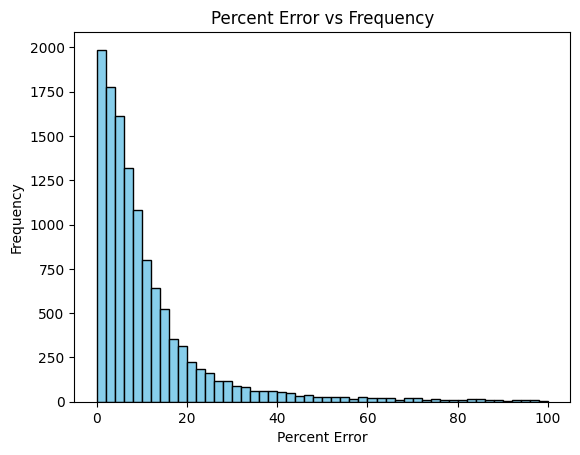

In [ ]:
percent_error = abs(1 - pred/true) * 100
plt.hist(percent_error, bins=50, color='skyblue', edgecolor='black', range=[0,100])
# sns.histplot(error, bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Percent Error')
plt.ylabel('Frequency')
plt.title('Percent Error vs Frequency')

plt.show()

In [ ]:
test = random.randint(0, len(int_test)-1)
true = [logP_test[test],qed_test[test],SAS_test[test]]
for i in range(3):
    pred = nn.predict(np.expand_dims(int_test[test],0),verbose=0)[i][0,0]
    perError = abs(1-pred/true[i]) * 100
    print(f"True = {true[i]:.4f}")
    print(f"Pred = {pred:.4f}")
    print(f"% error = {perError:.4f}%\n")

True = 2.8313
Pred = 2.5488
% error = 9.9783%

True = 0.8128
Pred = 0.8066
% error = 0.7581%

True = 3.7774
Pred = 3.7763
% error = 0.0278%



In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

# Tuning

# Testing

# POINTS

Recommnedations
1.   **Reversible.** Given a desriable output properties, give a molecule. Always valid molecule due to SELFIES. However, inverse of ReLU is not a function :(
2.   List item



# Other COde

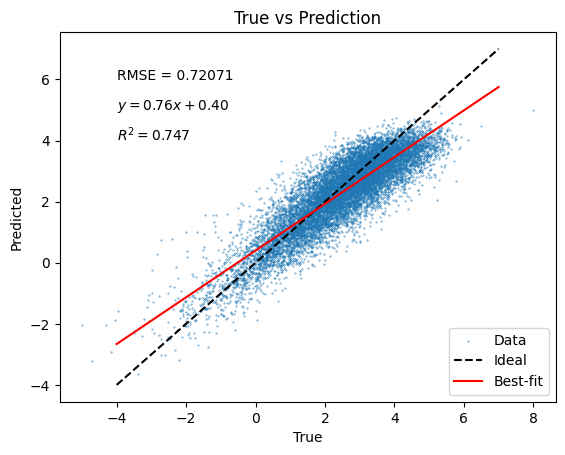

In [ ]:
#@title True vs Prediction Graph {vertical-output: true}
lim = np.array([-4,7])

prop_predict = nn.predict(int_test,verbose=0)[0]
plt.scatter(logP_test, prop_predict, s=0.1)

plt.plot(lim, lim, label='y = x', color='black', linestyle='dashed')

m, b = np.polyfit(logP_test, prop_predict, 1)
plt.plot(lim, m*lim+b, color='red')

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Prediction')

plt.text(-4, 6, f'RMSE = {math.sqrt(nn.evaluate(int_test,logP_test,verbose=0)):.5f}', fontsize = 10)
plt.text(-4, 5, f'$y = {m[0]:.2f}x + {b[0]:.2f}$', fontsize = 10)
plt.text(-4, 4, f'$R^2 = {r2_score(logP_test, prop_predict):.3f}$', fontsize = 10)

plt.legend(['Data', 'Ideal', 'Best-fit'], loc="lower right")

plt.show()

In [ ]:
# @title Example form fields
# @markdown Forms support many types of fields.

no_type_checking = 'power'  # @param
string_type = 'example'  # @param {type: "string"}
slider_value = 136  # @param {type: "slider", min: 100, max: 200}
number = 102  # @param {type: "number"}
date = '2010-11-05'  # @param {type: "date"}
pick_me = "monday"  # @param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "bananas" # @param ["apples", "bananas", "oranges"] {allow-input: true}
# @markdown ---


Model: "NeuralNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 TokenEmbedding (Embedding)  (None, 72, 64)            6912      
                                                                 
 DenseExpand (Dense)         (None, 72, 64)            4160      
                                                                 
 DenseExpand2 (Dense)        (None, 72, 108)           7020      
                                                                 
 DenseExpand3 (Dense)        (None, 72, 108)           11772     
                                                                 
 GlobalAveragePooling1D (Gl  (None, 108)               0         
 obalAveragePooling1D)                                           
                                                                 
 DenseShrink (Dense)         (None, 54)                5886      
                                                     

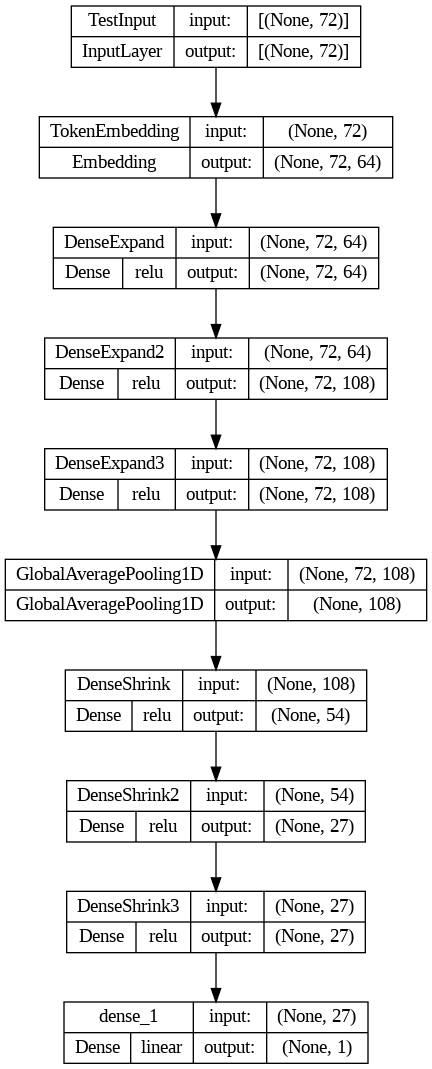

In [ ]:
#@title {vertical-output: true}
embed_dim = 64
nn = Sequential(
    [
        Input((max_length,), dtype='int32', name='TestInput'),
        Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=max_length,
            trainable=True,
            mask_zero=True,
            name='TokenEmbedding',
        ),
        Dense(embed_dim, activation='relu', name="DenseExpand"),
        Dense(vocab_size, activation='relu', name="DenseExpand2"),
        Dense(vocab_size, activation='relu', name="DenseExpand3"),
        GlobalAveragePooling1D(name="GlobalAveragePooling1D"),
        Dense(vocab_size/2, activation='relu', name="DenseShrink"),
        Dense(vocab_size/4, activation='relu', name="DenseShrink2"),
        Dense(vocab_size/4, activation='relu', name="DenseShrink3"),
        Dense(1, activation='linear')
    ]
, name="NeuralNetwork")

nn.compile(optimizer = "adam", loss = 'mse')
nn.summary()

keras.utils.plot_model(
    nn,
    to_file="modelTestNN.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
    show_layer_activations=True,
)

In [ ]:
validation_data=(int_train[10001:11000], [logP_train[10001:11000],qed_train[10001:11000],SAS_train[10001:11000]]),

In [ ]:
def build_model(hp):
    model = Sequential(name="NeuralNetwork")
    model.add(Input((max_length,), dtype='int32', name='TestInput'))
    embed_dim = hp.Choice("embed_dim", [64, 128])
    model.add(Embedding(
                input_dim=vocab_size,
                output_dim=64,
                input_length=max_length,
                mask_zero=True,
                name='TokenEmbedding',
            ))

    if hp.Boolean("convolution"):
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

    num_expand_layers = hp.Int("num_expand_layers", 1, 3)
    activation_Expand = hp.Choice("activationExpand", ["relu", "tanh"])
    for i in range(num_expand_layers):
        with hp.conditional_scope("num_expand_layers", list(range(i + 1, 3 + 1))):
            model.add(
                Dense(
                        units=hp.Int(f"unitsExpand_{i+1}", min_value=32, max_value=64, step=32),
                        activation=activation_Expand,
                        name=f"DenseExpand{i+1}"
                    )
                )

    pooling_type = hp.Choice("PoolingType", ["Average","Max"])
    if pooling_type == "Average":
        model.add(GlobalAveragePooling1D(name="GlobalAveragePooling1D"))
    elif pooling_type == "Max":
        model.add(GlobalMaxPooling1D(name="GlobalMaxPooling1D"))

    num_shrink_layers = hp.Int("num_shrink_layers", 1, 3)
    activation_Shrink = hp.Choice("activationShrink", ["relu", "tanh"])
    for i in range(num_shrink_layers):
        with hp.conditional_scope("num_shrink_layers", list(range(i + 1, 3 + 1))):
            model.add(
                Dense(
                        units=hp.Int(f"unitsShrink_{i+1}", min_value=26, max_value=39, step=13),
                        activation=activation_Shrink,
                        name=f"DenseShrink{i+1}"
                    )
                )
    model.add(Dense(1, activation='linear', name="Linear"))

    model.compile(loss='mse')
    return model

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=20,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    overwrite=True,
    directory="/tmp/tb",
)

tuner.search_space_summary()

In [ ]:
tuner.search(int_train[:10000], logP_train[:10000], epochs=10, validation_data=(int_train[10001:11000], logP_train[10001:11000]), callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],)
best_model = tuner.get_best_models()[0]
best_model.summary()
tuner.results_summary()

In [ ]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable python-markdown/main

In [ ]:
from IPython.display import Markdown as md
md(f"The data consists of {max_length} observations. Bla, Bla, ....")
# print(f"The data consists of {max_length} observations. Bla, Bla, ....")

In [ ]:
def build_model(hp):
    embed_dim = hp.Choice("embed_dim", [64, 128])
    model = Sequential(
        [
            Input((max_length,), dtype='int32', name='TestInput'),
            Embedding(
                input_dim=vocab_size,
                output_dim=embed_dim,
                input_length=max_length,
                mask_zero=True,
                name='TokenEmbedding',
            ),
            Dense(embed_dim, activation='relu', name="DenseExpand"),
            Dense(vocab_size, activation='relu', name="DenseExpand2"),
            Dense(vocab_size, activation='relu', name="DenseExpand3"),
            GlobalAveragePooling1D(name="GlobalAveragePooling1D"),
            Dense(vocab_size/2, activation='relu', name="DenseShrink"),
            Dense(vocab_size/4, activation='relu', name="DenseShrink2"),
            Dense(hp.Choice('units', [13, 27]), activation='relu', name="DenseShrink3"),
            Dense(1, activation='linear')
        ]
    , name="NeuralNetwork")
    model.compile(optimizer = "adam", loss = 'mse')
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    project_name="KerasTuner",
)

tuner.search_space_summary()
tuner.search(int_train[:2000], logP_train[:2000], epochs=3, validation_data=(int_train[2001:2500], logP_train[2001:2500]))
best_model = tuner.get_best_models()[0]

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    # project_name="KerasTuner",
    overwrite=True,
    directory="/tmp/tb",
)